In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, recall_score
from tqdm.auto import tqdm
import joblib
import time
import warnings

# Gereksiz uyarıları filtreleyerek çıktı temizliğini sağlıyoruz
warnings.filterwarnings("ignore")
print("Derin öğrenme kütüphaneleri başarıyla yüklendi.")

Derin öğrenme kütüphaneleri başarıyla yüklendi.


In [2]:
print("Veri yükleme işlemi başlatıldı (Base - 4 Özellik)...")

# Temel özellik seti tanımlanıyor
FEATURES_BASE = [
    'LOCATION_TYPE', 
    'ROAD_TYPE_ARTERIES_HIGHWAYS', 
    'ROAD_TYPE_LOCAL_MAIN_ROADS', 
    'ROAD_TYPE_SPECIAL_AREAS'
]
TARGET = "SEVERITY"

chunks = []
# Bellek yönetimi için 50.000 satırlık parçalar halinde okuma yapılıyor
for chunk in pd.read_csv("NYC_Crash_Model_Final_Last.csv", usecols=FEATURES_BASE + [TARGET], chunksize=50000):
    chunk = chunk.dropna()
    for col in chunk.columns:
        chunk[col] = chunk[col].astype('int8')
    chunks.append(chunk)

df_base = pd.concat(chunks, axis=0)
X_base = df_base[FEATURES_BASE]
y_base = df_base[TARGET]

print(f"Base veri seti yüklendi: {X_base.shape[0]} satır.")

Veri yükleme işlemi başlatıldı (Base - 4 Özellik)...
Base veri seti yüklendi: 1911073 satır.


In [3]:
# Verinin eğitim ve test setlerine ayrılması (%80 Eğitim, %20 Test)
X_train, X_test, y_train, y_test = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42, stratify=y_base
)

# Özellik ölçeklendirme (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PyTorch Tensor yapısına dönüştürme işlemi
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

# Veriyi 64'lük paketler (batch) halinde okumak için DataLoader yapısı kuruluyor
train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor), 
    batch_size=64, 
    shuffle=True
)

print("Veriler Tensor formatına dönüştürüldü ve DataLoader hazırlandı.")

Veriler Tensor formatına dönüştürüldü ve DataLoader hazırlandı.


In [4]:
# DERİN ÖĞRENME İÇİN KRİTİK ADIM: Tensor'e Çevirme
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

# DataLoader: Veriyi 64'lük paketlerle modele verir
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

print("Veriler Tensor formatına ve Loader'a hazırlandı.")

Veriler Tensor formatına ve Loader'a hazırlandı.


In [11]:
# Sinir ağı mimarisinin tanımlanması
class EnesMLP(nn.Module):
    def __init__(self, input_size):
        super(EnesMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x): 
        return self.network(x)

# Modelin ve optimizasyon kriterlerinin başlatılması
model_mlp = EnesMLP(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)

# Eğitim süreci
print("MLP Modeli eğitimi başlatılıyor...")
epochs = 10

for epoch in range(epochs):
    model_mlp.train()
    
    # tqdm ve progress_bar kaldırıldı, doğrudan train_loader kullanılıyor
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model_mlp(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    # Sadece epoch tamamlandığında bu mesaj yazdırılacak
    print(f"Epoch {epoch+1}/{epochs} tamamlandı.")

# Temel modelin kaydedilmesi
torch.save(model_mlp.state_dict(), "best_mlp_model_base.pth")
print("MLP Base modeli eğitildi ve kaydedildi.")

MLP Modeli eğitimi başlatılıyor...
Epoch 1/10 tamamlandı.
Epoch 2/10 tamamlandı.
Epoch 3/10 tamamlandı.
Epoch 4/10 tamamlandı.
Epoch 5/10 tamamlandı.
Epoch 6/10 tamamlandı.
Epoch 7/10 tamamlandı.
Epoch 8/10 tamamlandı.
Epoch 9/10 tamamlandı.
Epoch 10/10 tamamlandı.
MLP Base modeli eğitildi ve kaydedildi.


In [12]:
# GRU modeli için verinin 3 boyutlu hale getirilmesi (Batch, Zaman Adımı, Özellik Sayısı)
X_train_gru = X_train_tensor.unsqueeze(1)
X_test_gru = X_test_tensor.unsqueeze(1)

# GRU mimarisinin tanımlanması
class EnesGRU(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(EnesGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        _, hidden = self.gru(x)
        out = self.fc(hidden[-1])
        return self.sigmoid(out)

# Modelin başlatılması ve hiperparametrelerin ayarlanması
model_gru = EnesGRU(X_train.shape[1])
criterion = nn.BCELoss()
optimizer_gru = optim.Adam(model_gru.parameters(), lr=0.001)

# DataLoader oluşturulması
train_dataset_gru = TensorDataset(X_train_gru, y_train_tensor)
train_loader_gru = DataLoader(train_dataset_gru, batch_size=64, shuffle=True)

# Eğitim süreci
print("GRU Modeli eğitimi başlatılıyor...")
epochs = 10

for epoch in range(epochs):
    model_gru.train()
    
    # Progress bar ve süre takibi kaldırıldı
    for batch_X, batch_y in train_loader_gru:
        optimizer_gru.zero_grad()
        outputs = model_gru(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_gru.step()
    
    # Sadece epoch bittiğinde bilgi verir
    print(f"Epoch {epoch+1}/{epochs} tamamlandı.")

# Temel modelin kaydedilmesi
torch.save(model_gru.state_dict(), "best_gru_model_base.pth")
print("GRU Base modeli eğitildi ve kaydedildi.")

GRU Modeli eğitimi başlatılıyor...
Epoch 1/10 tamamlandı.
Epoch 2/10 tamamlandı.
Epoch 3/10 tamamlandı.
Epoch 4/10 tamamlandı.
Epoch 5/10 tamamlandı.
Epoch 6/10 tamamlandı.
Epoch 7/10 tamamlandı.
Epoch 8/10 tamamlandı.
Epoch 9/10 tamamlandı.
Epoch 10/10 tamamlandı.
GRU Base modeli eğitildi ve kaydedildi.


Modeller test ediliyor...


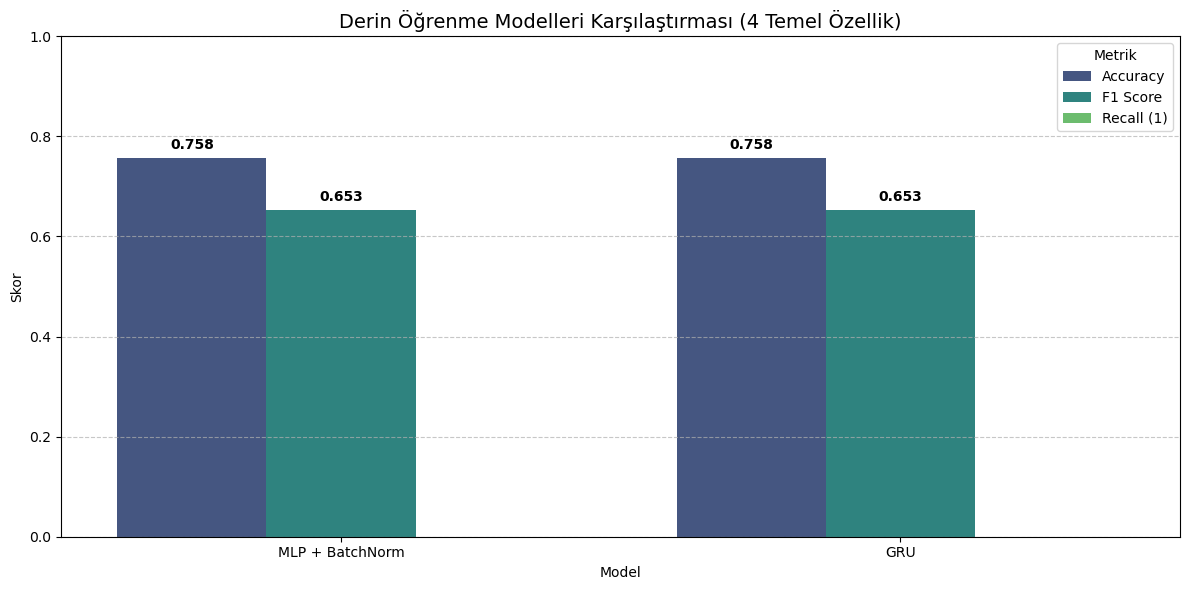

DERİN ÖĞRENME BASE MODEL SONUÇLARI


,Model,Accuracy,F1 Score,Recall (1)
0,MLP + BatchNorm,0.7576,0.653115,0.0
1,GRU,0.7576,0.653115,0.0


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Tahminlerin Alınması ve Değerlendirme
def derin_ogrenme_test(model, X_test_tensor, y_test, model_type="MLP"):
    model.eval()
    with torch.no_grad():
        if model_type == "GRU":
            # GRU 3 boyutlu veri bekler
            X_input = X_test_tensor.unsqueeze(1) if X_test_tensor.dim() == 2 else X_test_tensor
            outputs = model(X_input)
        else:
            outputs = model(X_test_tensor)
        
        # Olasılıkları 0 veya 1 sınıfına çeviriyoruz (Threshold: 0.5)
        preds = (outputs > 0.5).float().numpy()
    
    return {
        'Model': model_type,
        'Accuracy': accuracy_score(y_test, preds),
        'F1 Score': f1_score(y_test, preds, average='weighted'),
        'Recall (1)': recall_score(y_test, preds)
    }

# 2. Skorların Hesaplanması
print("Modeller test ediliyor...")
mlp_stats = derin_ogrenme_test(model_mlp, X_test_tensor, y_test, "MLP + BatchNorm")
gru_stats = derin_ogrenme_test(model_gru, X_test_tensor, y_test, "GRU")

# Sonuçları tabloya döküyoruz
df_dl_base = pd.DataFrame([mlp_stats, gru_stats])

# 3. GÖRSELLEŞTİRME
plt.figure(figsize=(12, 6))

# Tabloyu grafik formatına çeviriyoruz
df_plot = df_dl_base.melt(id_vars='Model', var_name='Metrik', value_name='Skor')

sns.barplot(data=df_plot, x='Model', y='Skor', hue='Metrik', palette='viridis')

plt.title('Derin Öğrenme Modelleri Karşılaştırması (4 Temel Özellik)', fontsize=14)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Değerleri barların üzerine ekleyelim
for p in plt.gca().patches:
    if p.get_height() > 0:
        plt.gca().annotate(f'{p.get_height():.3f}', 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha='center', va='center', xytext=(0, 9), 
                           textcoords='offset points', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

print("DERİN ÖĞRENME BASE MODEL SONUÇLARI")
display(df_dl_base)

In [5]:
print("Gelişmiş veri yükleme işlemi başlatıldı (Advanced - 6 Özellik)...")

# Yeni özellikler eklenmiş liste
FEATURES_ADV = [
    'LOCATION_TYPE', 
    'ROAD_TYPE_ARTERIES_HIGHWAYS', 
    'ROAD_TYPE_LOCAL_MAIN_ROADS', 
    'ROAD_TYPE_SPECIAL_AREAS',
    'IS_MULTI_VEHICLE', 
    'HOUR'
]

chunks = []
# Dosya tekrar okunuyor (Sadece gerekli kolonlar)
for chunk in pd.read_csv("NYC_Crash_Model_Final_Last.csv", usecols=FEATURES_ADV + [TARGET], chunksize=50000):
    chunk = chunk.dropna()
    for col in chunk.columns:
        chunk[col] = chunk[col].astype('int8')
    chunks.append(chunk)

df_adv = pd.concat(chunks, axis=0)
X_adv = df_adv[FEATURES_ADV]
y_adv = df_adv[TARGET]

print(f"Advanced veri seti yüklendi: {X_adv.shape[0]} satır ve {X_adv.shape[1]} özellik.")

Gelişmiş veri yükleme işlemi başlatıldı (Advanced - 6 Özellik)...
Advanced veri seti yüklendi: 1911073 satır ve 6 özellik.


In [6]:
# Eğitim ve test ayırımı
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
    X_adv, y_adv, test_size=0.2, random_state=42, stratify=y_adv
)

# Ölçeklendirme
scaler_adv = StandardScaler()
X_train_adv_scaled = scaler_adv.fit_transform(X_train_adv)
X_test_adv_scaled = scaler_adv.transform(X_test_adv)

# Tensor dönüşümü
X_train_adv_tensor = torch.FloatTensor(X_train_adv_scaled)
y_train_adv_tensor = torch.FloatTensor(y_train_adv.values).reshape(-1, 1)
X_test_adv_tensor = torch.FloatTensor(X_test_adv_scaled)
y_test_adv_tensor = torch.FloatTensor(y_test_adv.values).reshape(-1, 1)

# DataLoader (64'lük paketler)
train_loader_adv = DataLoader(
    TensorDataset(X_train_adv_tensor, y_train_adv_tensor), 
    batch_size=64, 
    shuffle=True
)

print("Advanced veriler için Tensor hazırlığı tamamlandı.")

Advanced veriler için Tensor hazırlığı tamamlandı.


In [16]:
# Yeni model nesnesi (Giriş boyutu 6)
model_mlp_adv = EnesMLP(input_size=X_train_adv.shape[1])
optimizer_adv = optim.Adam(model_mlp_adv.parameters(), lr=0.001)

print("Advanced MLP Modeli eğitimi başlatılıyor...")
epochs = 10

for epoch in range(epochs):
    model_mlp_adv.train()
    
    # tqdm ve progress_bar kaldırıldı, doğrudan train_loader_adv kullanılıyor
    for batch_X, batch_y in train_loader_adv:
        optimizer_adv.zero_grad()
        outputs = model_mlp_adv(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_adv.step()
    
    # Sadece epoch bittiğinde bu mesaj yazdırılır
    print(f"Epoch {epoch+1}/{epochs} tamamlandı.")

# Modeli kaydetme
torch.save(model_mlp_adv.state_dict(), "best_mlp_model_adv.pth")
print("MLP Advanced modeli başarıyla kaydedildi.")

Advanced MLP Modeli eğitimi başlatılıyor...
Epoch 1/10 tamamlandı.
Epoch 2/10 tamamlandı.
Epoch 3/10 tamamlandı.
Epoch 4/10 tamamlandı.
Epoch 5/10 tamamlandı.
Epoch 6/10 tamamlandı.
Epoch 7/10 tamamlandı.
Epoch 8/10 tamamlandı.
Epoch 9/10 tamamlandı.
Epoch 10/10 tamamlandı.
MLP Advanced modeli başarıyla kaydedildi.


In [17]:
# GRU için 3 boyutlu hale getirme
X_train_gru_adv = X_train_adv_tensor.unsqueeze(1)
X_test_gru_adv = X_test_adv_tensor.unsqueeze(1)

model_gru_adv = EnesGRU(input_size=X_train_adv.shape[1])
optimizer_gru_adv = optim.Adam(model_gru_adv.parameters(), lr=0.001)

train_loader_gru_adv = DataLoader(
    TensorDataset(X_train_gru_adv, y_train_adv_tensor), 
    batch_size=64, 
    shuffle=True
)

print("Advanced GRU Modeli eğitimi başlatılıyor...")
epochs = 10

for epoch in range(epochs):
    model_gru_adv.train()
    
    # tqdm ve progress_bar kaldırıldı
    for batch_X, batch_y in train_loader_gru_adv:
        optimizer_gru_adv.zero_grad()
        outputs = model_gru_adv(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_gru_adv.step()
    
    # Sadece epoch tamamlandığında çıktı verir
    print(f"Epoch {epoch+1}/{epochs} tamamlandı.")

# Modeli kaydetme
torch.save(model_gru_adv.state_dict(), "best_gru_model_adv.pth")
print("GRU Advanced modeli başarıyla kaydedildi.")

Advanced GRU Modeli eğitimi başlatılıyor...
Epoch 1/10 tamamlandı.
Epoch 2/10 tamamlandı.
Epoch 3/10 tamamlandı.
Epoch 4/10 tamamlandı.
Epoch 5/10 tamamlandı.
Epoch 6/10 tamamlandı.
Epoch 7/10 tamamlandı.
Epoch 8/10 tamamlandı.
Epoch 9/10 tamamlandı.
Epoch 10/10 tamamlandı.
GRU Advanced modeli başarıyla kaydedildi.


Dinamik karşılaştırma yapılıyor...


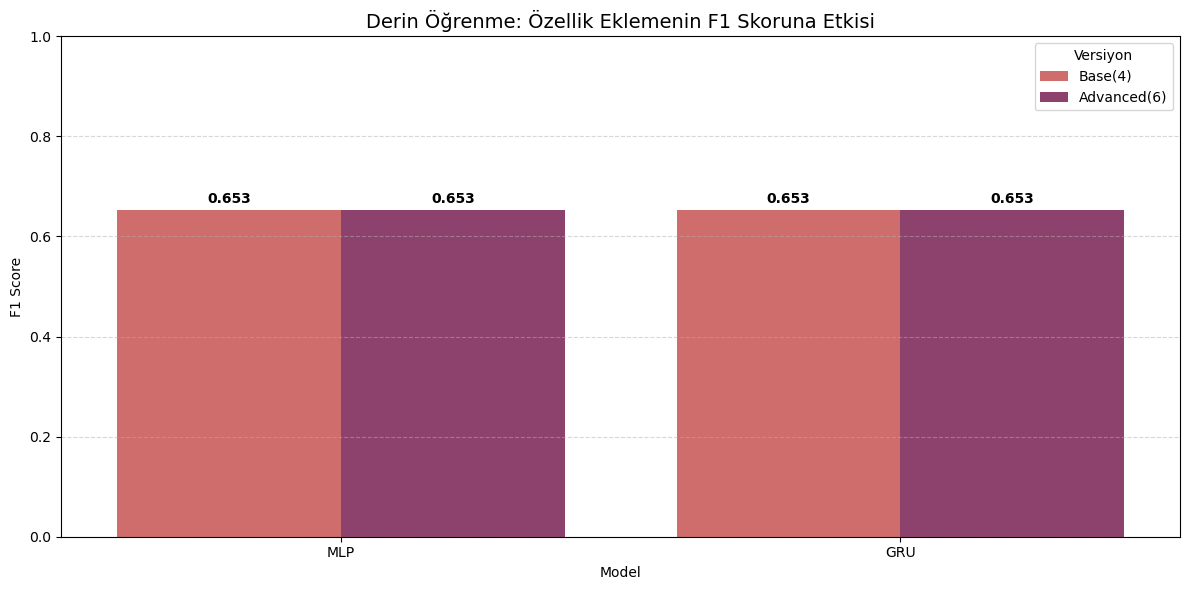

,Model,Versiyon,F1 Score,Accuracy
0,MLP,Base(4),0.653115,0.7576
1,GRU,Base(4),0.653115,0.7576
2,MLP,Advanced(6),0.653115,0.7576
3,GRU,Advanced(6),0.653115,0.7576


In [19]:
# Sonuçları toplamak için dinamik test fonksiyonu
def dl_performans_hesapla(model, X_input, y_true, label):
    model.eval()
    with torch.no_grad():
        outputs = model(X_input)
        preds = (outputs > 0.5).float().numpy()
    
    return {
        'Model': label.split(" ")[0],
        'Versiyon': " ".join(label.split(" ")[1:]),
        'F1 Score': f1_score(y_true, preds, average='weighted'),
        'Accuracy': accuracy_score(y_true, preds)
    }

print("Dinamik karşılaştırma yapılıyor...")
dl_results = []

# Base Modeller (4 özellikli verilerle test edilir)
dl_results.append(dl_performans_hesapla(model_mlp, X_test_tensor, y_test, "MLP Base(4)"))
dl_results.append(dl_performans_hesapla(model_gru, X_test_gru, y_test, "GRU Base(4)"))

# Advanced Modeller (6 özellikli verilerle test edilir)
dl_results.append(dl_performans_hesapla(model_mlp_adv, X_test_adv_tensor, y_test_adv, "MLP Advanced(6)"))
dl_results.append(dl_performans_hesapla(model_gru_adv, X_test_gru_adv, y_test_adv, "GRU Advanced(6)"))

df_dl_compare = pd.DataFrame(dl_results)

# Grafik
plt.figure(figsize=(12, 6))
sns.barplot(data=df_dl_compare, x='Model', y='F1 Score', hue='Versiyon', palette='flare')
plt.title('Derin Öğrenme: Özellik Eklemenin F1 Skoruna Etkisi', fontsize=14)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Değerleri yazdır
for p in plt.gca().patches:
    if p.get_height() > 0:
        plt.gca().annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha='center', va='center', xytext=(0, 8), textcoords='offset points', weight='bold')

plt.tight_layout()
plt.show()

display(df_dl_compare)

In [20]:
# --- İYİLEŞTİRİLMİŞ MLP EĞİTİMİ (WEIGHTED LOSS + DROPOUT) ---

# 1. Sınıf Ağırlıklarının Hesaplanması
sayi_0 = (y_train_adv == 0).sum()
sayi_1 = (y_train_adv == 1).sum()
pos_weight = torch.tensor([sayi_0 / sayi_1], dtype=torch.float)

# 2. Mimari Güncellemesi (Dropout ve Daha Geniş Katmanlar)
class EnesMLP_Improved(nn.Module):
    def __init__(self, input_size):
        super(EnesMLP_Improved, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3), 
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x): 
        return self.network(x)

# 3. Model, Loss ve Optimizer Kurulumu
model_mlp_improved = EnesMLP_Improved(X_train_adv.shape[1])
criterion_weighted = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model_mlp_improved.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

print("İyileştirilmiş MLP eğitimi başlatılıyor...")
epochs = 10

for epoch in range(epochs):
    model_mlp_improved.train()
    
    # tqdm ve progress_bar kaldırıldı
    for batch_X, batch_y in train_loader_adv:
        optimizer.zero_grad()
        outputs = model_mlp_improved(batch_X)
        loss = criterion_weighted(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    # Öğrenme hızı güncelleniyor
    scheduler.step()
    
    # Sadece epoch tamamlandığında bilgi verir
    print(f"Epoch {epoch+1}/{epochs} tamamlandı.")

# Modeli kaydetme
torch.save(model_mlp_improved.state_dict(), "best_mlp_model_improved.pth")
print("İyileştirilmiş MLP modeli başarıyla kaydedildi.")

İyileştirilmiş MLP eğitimi başlatılıyor...
Epoch 1/10 tamamlandı.
Epoch 2/10 tamamlandı.
Epoch 3/10 tamamlandı.
Epoch 4/10 tamamlandı.
Epoch 5/10 tamamlandı.
Epoch 6/10 tamamlandı.
Epoch 7/10 tamamlandı.
Epoch 8/10 tamamlandı.
Epoch 9/10 tamamlandı.
Epoch 10/10 tamamlandı.
İyileştirilmiş MLP modeli başarıyla kaydedildi.


In [21]:
# --- İYİLEŞTİRİLMİŞ GRU EĞİTİMİ (WEIGHTED LOSS) ---

class EnesGRU_Improved(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(EnesGRU_Improved, self).__init__()
        # num_layers=2 ve dropout eklenerek mimari güçlendirildi
        self.gru = nn.GRU(input_size, hidden_size, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        _, hidden = self.gru(x)
        # Çift katmanlı GRU olduğu için son katmanın gizli durumunu (hidden[-1]) alıyoruz
        out = self.fc(hidden[-1])
        return out

# Model ve optimizer kurulumu
model_gru_improved = EnesGRU_Improved(X_train_adv.shape[1])
optimizer_gru = optim.Adam(model_gru_improved.parameters(), lr=0.001)
criterion_weighted_gru = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

print("İyileştirilmiş GRU eğitimi başlatılıyor...")
epochs = 10

for epoch in range(epochs):
    model_gru_improved.train()
    
    # tqdm ve ilerleme çubuğu kaldırıldı
    for batch_X, batch_y in train_loader_gru_adv:
        optimizer_gru.zero_grad()
        outputs = model_gru_improved(batch_X)
        loss = criterion_weighted_gru(outputs, batch_y)
        loss.backward()
        optimizer_gru.step()
    
    # Sadece epoch bittiğinde bilgi mesajı yazdırılır
    print(f"Epoch {epoch+1}/{epochs} tamamlandı.")

# Modelin kaydedilmesi
torch.save(model_gru_improved.state_dict(), "best_gru_model_improved.pth")
print("İyileştirilmiş GRU modeli başarıyla kaydedildi.")

İyileştirilmiş GRU eğitimi başlatılıyor...
Epoch 1/10 tamamlandı.
Epoch 2/10 tamamlandı.
Epoch 3/10 tamamlandı.
Epoch 4/10 tamamlandı.
Epoch 5/10 tamamlandı.
Epoch 6/10 tamamlandı.
Epoch 7/10 tamamlandı.
Epoch 8/10 tamamlandı.
Epoch 9/10 tamamlandı.
Epoch 10/10 tamamlandı.
İyileştirilmiş GRU modeli başarıyla kaydedildi.


In [51]:
# 1. Mimariyi Büyütüyoruz (256 - 128 - 64)
class UltimateMLP(nn.Module):
    def __init__(self, input_size):
        super(UltimateMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4), # Ezberlemeye karşı önlem
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x): 
        return self.network(x)

# 2. Ayarlar ve Early Stopping Hazırlığı
model_ultimate = UltimateMLP(X_train_adv.shape[1])
criterion_ultimate = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model_ultimate.parameters(), lr=0.001)

patience = 5 
best_loss = float('inf')
counter = 0
epochs = 20

print("Ultimate MLP Eğitimi Başlıyor...")

for epoch in range(epochs):
    model_ultimate.train()
    epoch_loss = 0
    
    # tqdm ve ilerleme çubuğu kaldırıldı
    for batch_X, batch_y in train_loader_adv:
        optimizer.zero_grad()
        outputs = model_ultimate(batch_X)
        loss = criterion_ultimate(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader_adv)
    
    # Early Stopping Kontrolü
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model_ultimate.state_dict(), "ultimate_mlp_model.pth")
        counter = 0
        print(f"Epoch {epoch+1}/{epochs} tamamlandı. (Yeni en iyi model kaydedildi)")
    else:
        counter += 1
        print(f"Epoch {epoch+1}/{epochs} tamamlandı.")
        if counter >= patience:
            print(f"Sabır tükendi! Eğitim {epoch+1}. epochta durduruldu.")
            break

print("Ultimate MLP eğitimi başarıyla tamamlandı.")

Ultimate MLP Eğitimi Başlıyor...
Epoch 1/20 tamamlandı. (Yeni en iyi model kaydedildi)
Epoch 2/20 tamamlandı. (Yeni en iyi model kaydedildi)
Epoch 3/20 tamamlandı. (Yeni en iyi model kaydedildi)
Epoch 4/20 tamamlandı. (Yeni en iyi model kaydedildi)
Epoch 5/20 tamamlandı. (Yeni en iyi model kaydedildi)
Epoch 6/20 tamamlandı. (Yeni en iyi model kaydedildi)
Epoch 7/20 tamamlandı. (Yeni en iyi model kaydedildi)
Epoch 8/20 tamamlandı. (Yeni en iyi model kaydedildi)
Epoch 9/20 tamamlandı. (Yeni en iyi model kaydedildi)
Epoch 10/20 tamamlandı. (Yeni en iyi model kaydedildi)
Epoch 11/20 tamamlandı. (Yeni en iyi model kaydedildi)
Epoch 12/20 tamamlandı.
Epoch 13/20 tamamlandı.
Epoch 14/20 tamamlandı. (Yeni en iyi model kaydedildi)
Epoch 15/20 tamamlandı. (Yeni en iyi model kaydedildi)
Epoch 16/20 tamamlandı.
Epoch 17/20 tamamlandı. (Yeni en iyi model kaydedildi)
Epoch 18/20 tamamlandı. (Yeni en iyi model kaydedildi)
Epoch 19/20 tamamlandı.
Epoch 20/20 tamamlandı. (Yeni en iyi model kaydedildi)


In [16]:
# --- 1D-CNN: ÖZELLİK TARAYICI MİMARİ ---
# --- İYİLEŞTİRİLMİŞ MLP EĞİTİMİ (WEIGHTED LOSS + DROPOUT) ---

# 1. Sınıf Ağırlıklarının Hesaplanması
sayi_0 = (y_train_adv == 0).sum()
sayi_1 = (y_train_adv == 1).sum()
pos_weight = torch.tensor([sayi_0 / sayi_1], dtype=torch.float)

class EnesCNN1D(nn.Module):
    def __init__(self, input_size):
        super(EnesCNN1D, self).__init__()
        # 1D-CNN veriyi (Batch, Kanal, Uzunluk) formatında bekler
        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2), # Özellikleri 2'şerli tarar
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2),
            nn.ReLU(),
            nn.Flatten()
        )
        # 64 kanal * 4 = 256
        self.fc_block = nn.Sequential(
            nn.Linear(64 * 4, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x: (Batch, 6) -> (Batch, 1, 6)
        x = x.unsqueeze(1)
        x = self.conv_block(x)
        return self.fc_block(x)

# Model ve Loss Ayarları
model_cnn = EnesCNN1D(input_size=6)
criterion_cnn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)

print("1D-CNN Modeli Eğitimi Başlatılıyor...")
epochs = 25

for epoch in range(epochs):
    model_cnn.train()
    
    # tqdm ve ilerleme çubuğu kaldırıldı
    for batch_X, batch_y in train_loader_adv:
        optimizer_cnn.zero_grad()
        outputs = model_cnn(batch_X)
        loss = criterion_cnn(outputs, batch_y)
        loss.backward()
        optimizer_cnn.step()
    
    # Sadece epoch bittiğinde bilgi mesajı yazdırılır
    print(f"Epoch {epoch+1}/{epochs} tamamlandı.")

# Modelin kaydedilmesi
torch.save(model_cnn.state_dict(), "best_cnn1d_model.pth")
print("1D-CNN modeli eğitildi ve başarıyla kaydedildi.")

1D-CNN Modeli Eğitimi Başlatılıyor...
Epoch 1/25 tamamlandı.
Epoch 2/25 tamamlandı.
Epoch 3/25 tamamlandı.
Epoch 4/25 tamamlandı.
Epoch 5/25 tamamlandı.
Epoch 6/25 tamamlandı.
Epoch 7/25 tamamlandı.
Epoch 8/25 tamamlandı.
Epoch 9/25 tamamlandı.
Epoch 10/25 tamamlandı.
Epoch 11/25 tamamlandı.
Epoch 12/25 tamamlandı.
Epoch 13/25 tamamlandı.
Epoch 14/25 tamamlandı.
Epoch 15/25 tamamlandı.
Epoch 16/25 tamamlandı.
Epoch 17/25 tamamlandı.
Epoch 18/25 tamamlandı.
Epoch 19/25 tamamlandı.
Epoch 20/25 tamamlandı.
Epoch 21/25 tamamlandı.
Epoch 22/25 tamamlandı.
Epoch 23/25 tamamlandı.
Epoch 24/25 tamamlandı.
Epoch 25/25 tamamlandı.
1D-CNN modeli eğitildi ve başarıyla kaydedildi.


In [8]:
# --- RESIDUAL MLP: DERİN VE KÖPRÜLÜ MİMARİ ---
# 1. Sınıf Ağırlıklarının Hesaplanması
sayi_0 = (y_train_adv == 0).sum()
sayi_1 = (y_train_adv == 1).sum()
pos_weight = torch.tensor([sayi_0 / sayi_1], dtype=torch.float)

class ResBlock(nn.Module):
    def __init__(self, size):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(size, size),
            nn.BatchNorm1d(size),
            nn.ReLU(),
            nn.Linear(size, size),
            nn.BatchNorm1d(size)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        # Girdi + İşlenmiş Girdi (ResNet mantığı: Skip Connection)
        return self.relu(x + self.block(x)) 

class EnesResNet(nn.Module):
    def __init__(self, input_size):
        super(EnesResNet, self).__init__()
        self.init_layer = nn.Linear(input_size, 128)
        self.res_blocks = nn.Sequential(
            ResBlock(128),
            ResBlock(128)
        )
        self.output_layer = nn.Linear(128, 1)

    def forward(self, x):
        x = self.init_layer(x)
        x = self.res_blocks(x)
        return self.output_layer(x)

# Model ve Loss Ayarları
model_resnet = EnesResNet(input_size=6)
criterion_resnet = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.001)

print("Residual MLP (ResNet) Eğitimi Başlatılıyor...")
epochs = 20

for epoch in range(epochs):
    model_resnet.train()
    
    # tqdm ve ilerleme çubuğu kaldırıldı
    for batch_X, batch_y in train_loader_adv:
        optimizer_resnet.zero_grad()
        outputs = model_resnet(batch_X)
        loss = criterion_resnet(outputs, batch_y)
        loss.backward()
        optimizer_resnet.step()
    
    # Sadece epoch tamamlandığında çıktı verir
    print(f"Epoch {epoch+1}/{epochs} tamamlandı.")

# Modelin kaydedilmesi
torch.save(model_resnet.state_dict(), "best_resnet_model.pth")
print("Residual MLP (ResNet) modeli başarıyla eğitildi ve kaydedildi.")

Residual MLP (ResNet) Eğitimi Başlatılıyor...
Epoch 1/20 tamamlandı.
Epoch 2/20 tamamlandı.
Epoch 3/20 tamamlandı.
Epoch 4/20 tamamlandı.
Epoch 5/20 tamamlandı.
Epoch 6/20 tamamlandı.
Epoch 7/20 tamamlandı.
Epoch 8/20 tamamlandı.
Epoch 9/20 tamamlandı.
Epoch 10/20 tamamlandı.
Epoch 11/20 tamamlandı.
Epoch 12/20 tamamlandı.
Epoch 13/20 tamamlandı.
Epoch 14/20 tamamlandı.
Epoch 15/20 tamamlandı.
Epoch 16/20 tamamlandı.
Epoch 17/20 tamamlandı.
Epoch 18/20 tamamlandı.
Epoch 19/20 tamamlandı.
Epoch 20/20 tamamlandı.
Residual MLP (ResNet) modeli başarıyla eğitildi ve kaydedildi.


In [31]:
# Modeli yeniden tanımlıyoruz
model_mlp_improved = EnesMLP_Improved(input_size=6)

# Kaydedilen ağırlıkları yüklüyoruz (Dosya adının doğru olduğundan emin olun)
if os.path.exists("best_mlp_model_improved.pth"):
    model_mlp_improved.load_state_dict(torch.load("best_mlp_model_improved.pth"))
    model_mlp_improved.eval()
    print("model_mlp_improved başarıyla yüklendi.")
else:
    print("Model dosyası bulunamadı, lütfen önce eğitimi tamamlayın.")

model_mlp_improved başarıyla yüklendi.


Yeni nesil modeller test ediliyor...


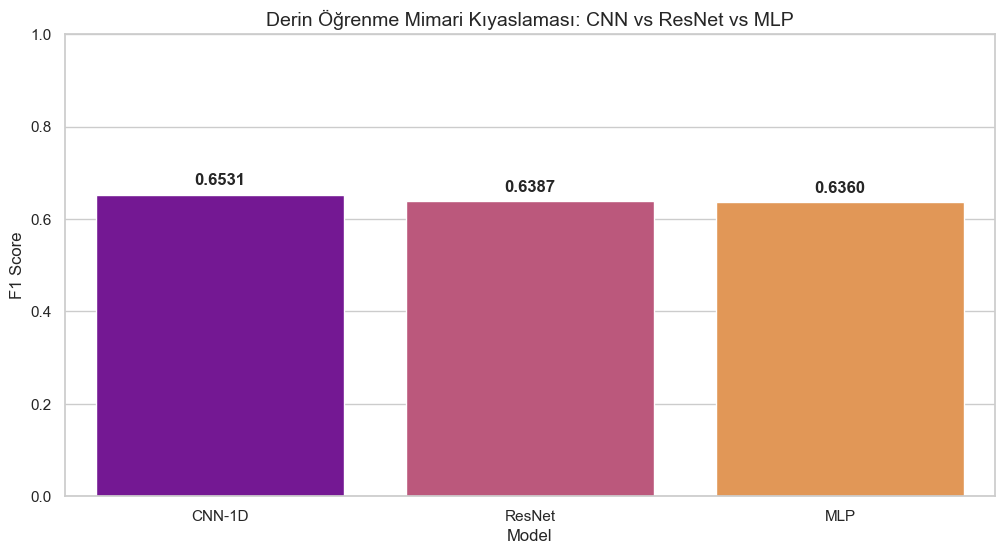

,Model,Versiyon,F1 Score,Recall (1),Accuracy
0,CNN-1D,Improved,0.653115,0.000000,0.757600
1,ResNet,Improved,0.638718,0.479735,0.615967
2,MLP,Improved,0.635979,0.489773,0.612239


In [32]:
# --- YENİ NESİL MODELLERİN ANALİZİ ---
class EnesMLP_Improved(nn.Module):
    def __init__(self, input_size):
        super(EnesMLP_Improved, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Linear(64, 1)
        )
    def forward(self, x): return self.network(x)

# --- EKSİK OLAN CNN-1D MİMARİSİ ---
class EnesCNN1D(nn.Module):
    def __init__(self, input_size):
        super(EnesCNN1D, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=2), nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=2), nn.ReLU(),
            nn.Flatten()
        )
        self.fc_block = nn.Sequential(
            nn.Linear(64 * 4, 64), nn.ReLU(), nn.Linear(64, 1)
        )
    def forward(self, x):
        x = x.unsqueeze(1) # (Batch, 1, Features)
        return self.fc_block(self.conv_block(x))

# --- EKSİK OLAN RESNET MİMARİSİ ---
class ResBlock(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.block = nn.Sequential(nn.Linear(size, size), nn.ReLU(), nn.Linear(size, size))
    def forward(self, x): return torch.relu(x + self.block(x))

class EnesResNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.init = nn.Linear(input_size, 128)
        self.res = ResBlock(128)
        self.out = nn.Linear(128, 1)
    def forward(self, x): return self.out(self.res(self.init(x)))


print("Yeni nesil modeller test ediliyor...")
new_dl_results = []
# Model ve Loss Ayarları
model_cnn = EnesCNN1D(input_size=6)
criterion_cnn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)

new_dl_results.append(dl_final_test(model_cnn, X_test_adv_tensor, y_test_adv, "CNN-1D Improved"))
new_dl_results.append(dl_final_test(model_resnet, X_test_adv_tensor, y_test_adv, "ResNet Improved"))
# Eski en iyi sonuçları da ekleyelim (Kıyas için)
new_dl_results.append(dl_final_test(model_mlp_improved, X_test_adv_tensor, y_test_adv, "MLP Improved"))

df_new_dl = pd.DataFrame(new_dl_results)

# Görselleştirme
plt.figure(figsize=(12, 6))
sns.barplot(data=df_new_dl, x='Model', y='F1 Score', palette='plasma')
plt.title('Derin Öğrenme Mimari Kıyaslaması: CNN vs ResNet vs MLP', fontsize=14)
plt.ylim(0, 1.0)

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points', weight='bold')

plt.show()
display(df_new_dl)

In [18]:
print("***TÜM MODEL DENEMELERİM BİTTİ. ŞİMDİ TÜM MODELLERİ KARŞILAŞTIRMA VE GRAFİKLEŞTİRME ZAMANI***")

***TÜM MODEL DENEMELERİM BİTTİ. ŞİMDİ TÜM MODELLERİ KARŞILAŞTIRMA VE GRAFİKLEŞTİRME ZAMANI***


In [33]:
import os
import joblib
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Gereksiz uyarıları kapatıyoruz ve görsel stili ayarlıyoruz
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
print("Bölüm 1: Kütüphaneler ve çevre ayarları başarıyla tamamlandı.")

Bölüm 1: Kütüphaneler ve çevre ayarları başarıyla tamamlandı.


Bölüm 2: Veri seti yükleniyor ve sınıf dağılımı analiz ediliyor...


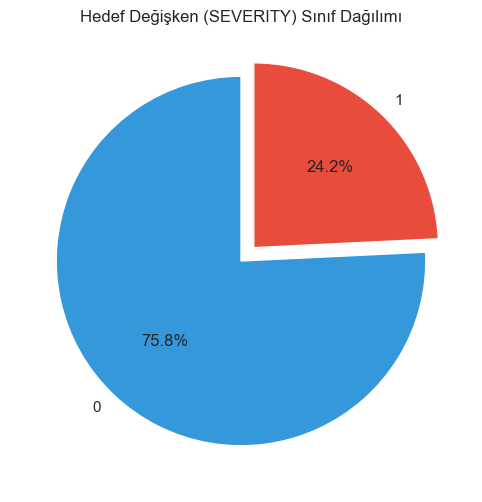

Veri Seti Boyutu: 1911073 satır.


In [34]:
print("Bölüm 2: Veri seti yükleniyor ve sınıf dağılımı analiz ediliyor...")

# Veri setinin yüklenmesi
df = pd.read_csv("NYC_Crash_Model_Final_Last.csv").dropna()

# Pasta Grafiği (Pie Chart) ile Sınıf Dağılımı
plt.figure(figsize=(8, 6))
df['SEVERITY'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#3498db', '#e74c3c'], startangle=90, explode=(0, 0.1))
plt.title("Hedef Değişken (SEVERITY) Sınıf Dağılımı")
plt.ylabel("")
plt.show()

print(f"Veri Seti Boyutu: {df.shape[0]} satır.")

In [35]:
print("Bölüm 3: Final modelleri için 6 özellikli test verisi hazırlanıyor...")

FEATURES_6 = ['LOCATION_TYPE', 'ROAD_TYPE_ARTERIES_HIGHWAYS', 'ROAD_TYPE_LOCAL_MAIN_ROADS', 
              'ROAD_TYPE_SPECIAL_AREAS', 'IS_MULTI_VEHICLE', 'HOUR']
TARGET = "SEVERITY"

# Train-Test ayırımı
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df[FEATURES_6], df[TARGET], test_size=0.2, random_state=42, stratify=df[TARGET]
)

# Ölçeklendirme ve sütun isimlerini koruma (UserWarning engelleyici)
scaler = StandardScaler().fit(X_train_raw)
X_test_scaled_named = pd.DataFrame(scaler.transform(X_test_raw), columns=FEATURES_6)
X_test_tensor = torch.FloatTensor(X_test_scaled_named.values)

Bölüm 3: Final modelleri için 6 özellikli test verisi hazırlanıyor...


In [36]:
print("Bölüm 4: PyTorch mimarileri (MLP, GRU, CNN) sisteme tanımlanıyor...")

class EnesMLP_Improved(nn.Module):
    def __init__(self, input_size):
        super(EnesMLP_Improved, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Linear(64, 1)
        )
    def forward(self, x): return self.network(x)

class EnesGRU_Improved(nn.Module):
    def __init__(self, input_size):
        super(EnesGRU_Improved, self).__init__()
        self.gru = nn.GRU(input_size, 128, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(128, 1)
    def forward(self, x):
        _, h = self.gru(x); return self.fc(h[-1])

Bölüm 4: PyTorch mimarileri (MLP, GRU, CNN) sisteme tanımlanıyor...


In [37]:
print("Bölüm 5: Kayıtlı modeller diskten okunuyor ve canlı performans testi yapılıyor...")

# Sadece final modelleri listesi
final_model_files = {
    "CatBoost v2": "best_catboost_model_enes_v2.pkl",
    "HistGB v2": "best_hgb_model_enes_v2.pkl",
    "MLP Improved": "best_mlp_model_improved.pth",
    "GRU Improved": "best_gru_model_improved.pth"
}

results = []
roc_data = {}

for name, path in final_model_files.items():
    if not os.path.exists(path): continue
    
    # ML Modelleri
    if path.endswith('.pkl'):
        model = joblib.load(path)
        test_in = X_test_raw if "catboost" in path.lower() else X_test_scaled_named
        preds = model.predict(test_in)
        probs = model.predict_proba(test_in)[:, 1] if hasattr(model, "predict_proba") else preds
        
    # DL Modelleri
    elif path.endswith('.pth'):
        m_obj = EnesMLP_Improved(6) if "mlp" in path else EnesGRU_Improved(6)
        m_obj.load_state_dict(torch.load(path)); m_obj.eval()
        with torch.no_grad():
            x_dl = X_test_tensor if "mlp" in path else X_test_tensor.unsqueeze(1)
            out = m_obj(x_dl)
            probs = torch.sigmoid(out).numpy().flatten()
            preds = (probs > 0.5).astype(int)

    results.append({
        "Model": name, "Accuracy": accuracy_score(y_test, preds),
        "Recall (1)": recall_score(y_test, preds), "F1": f1_score(y_test, preds, average='weighted'),
        "Sınıf 0 Recall": recall_score(y_test, preds, pos_label=0)
    })
    roc_data[name] = probs

df_res = pd.DataFrame(results)

Bölüm 5: Kayıtlı modeller diskten okunuyor ve canlı performans testi yapılıyor...


In [38]:
def bold_best(s):
    return ['font-weight: bold' if v == s.max() else '' for v in s]

print("\n--- TABLO 5a: GENEL PERFORMANS KARŞILAŞTIRMASI ---")
display(df_res[["Model", "Accuracy", "Recall (1)", "F1"]].style.apply(bold_best, subset=["Accuracy", "Recall (1)", "F1"]))

print("\n--- TABLO 5b: SINIF BAZLI (CLASS LABEL) BAŞARIM KIRILIMI ---")
display(df_res[["Model", "Sınıf 0 Recall", "Recall (1)"]].style.apply(bold_best, subset=["Sınıf 0 Recall", "Recall (1)"]))


--- TABLO 5a: GENEL PERFORMANS KARŞILAŞTIRMASI ---


,Model,Accuracy,Recall (1),F1
0,CatBoost v2,0.612142,0.487722,0.635811
1,HistGB v2,0.381516,0.840732,0.372782
2,MLP Improved,0.612239,0.489773,0.635979
3,GRU Improved,0.587481,0.536552,0.615892



--- TABLO 5b: SINIF BAZLI (CLASS LABEL) BAŞARIM KIRILIMI ---


,Model,Sınıf 0 Recall,Recall (1)
0,CatBoost v2,0.651952,0.487722
1,HistGB v2,0.234586,0.840732
2,MLP Improved,0.651423,0.489773
3,GRU Improved,0.603776,0.536552


Bölüm 7: Modellerin ROC Curve grafikleri oluşturuluyor...


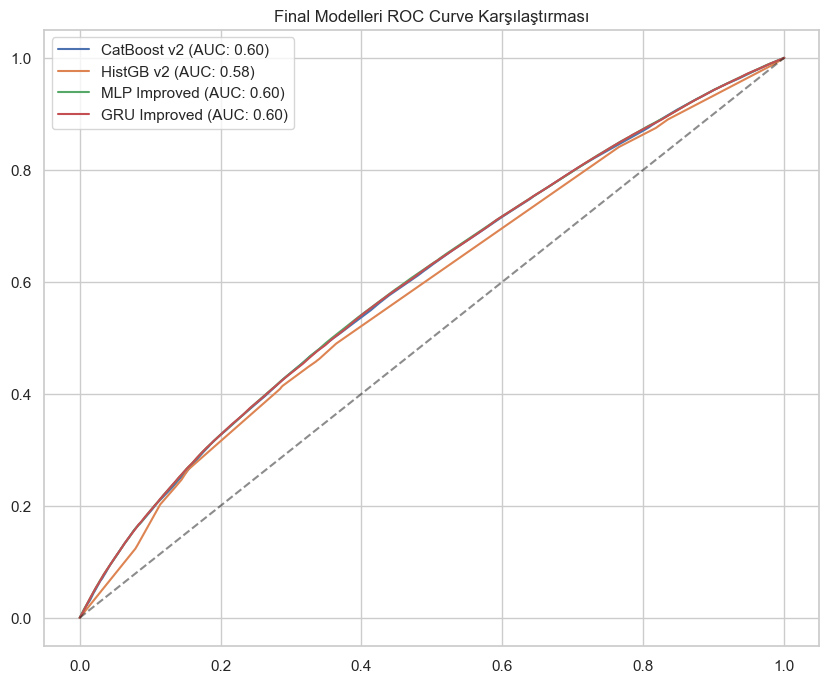

In [39]:
print("Bölüm 7: Modellerin ROC Curve grafikleri oluşturuluyor...")
plt.figure(figsize=(10, 8))
for name, probs in roc_data.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC: {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title("Final Modelleri ROC Curve Karşılaştırması")
plt.legend()
plt.show()

Bölüm 8: Final modelleri için Confusion Matrix (Hata Matrisi) çiziliyor...


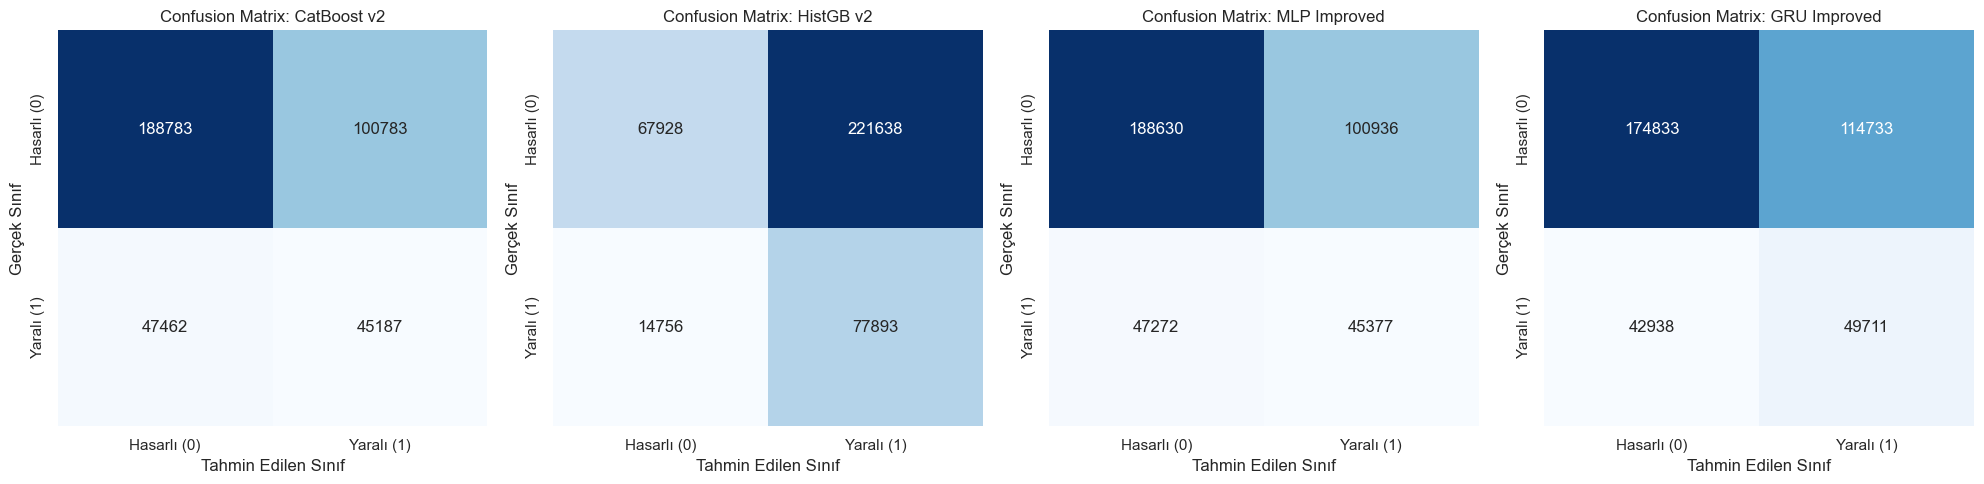

(None,)

In [40]:
from sklearn.metrics import confusion_matrix

print("Bölüm 8: Final modelleri için Confusion Matrix (Hata Matrisi) çiziliyor...")

# Grafik alanını model sayısına göre ayarlıyoruz
fig, axes = plt.subplots(1, len(results), figsize=(20, 5))
if len(results) == 1: axes = [axes] # Tek model varsa liste yapısı korunur

for i, res in enumerate(results):
    # Karmaşıklık matrisini hesapla
    cm = confusion_matrix(y_test, res["Preds"]) if "Preds" in res else confusion_matrix(y_test, (roc_data[res["Model"]] > 0.5).astype(int))
    
    # Heatmap ile görselleştir
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(f"Confusion Matrix: {res['Model']}")
    axes[i].set_xlabel('Tahmin Edilen Sınıf')
    axes[i].set_ylabel('Gerçek Sınıf')
    axes[i].set_xticklabels(['Hasarlı (0)', 'Yaralı (1)'])
    axes[i].set_yticklabels(['Hasarlı (0)', 'Yaralı (1)'])

plt.tight_layout()
plt.show(),

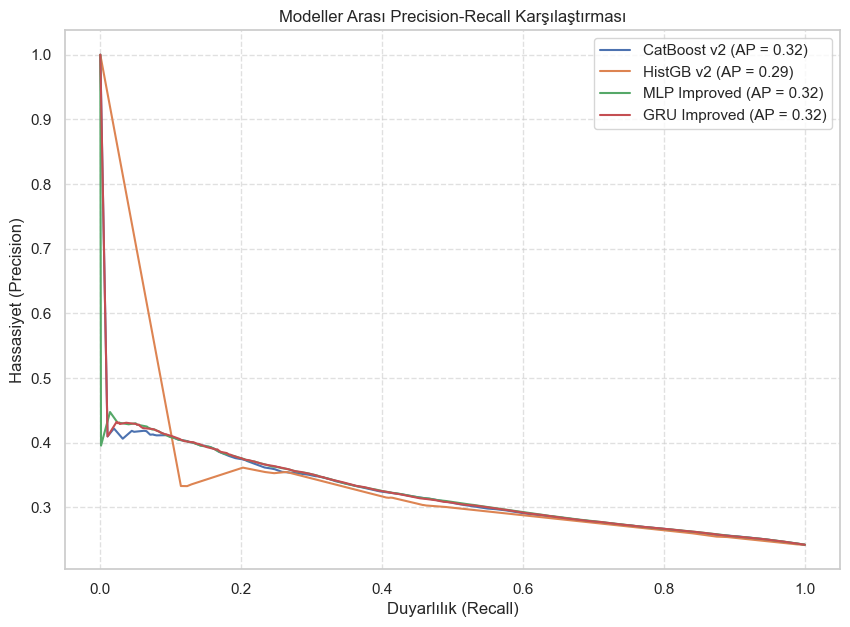

In [41]:
import matplotlib.pyplot as plt # Bu satır eksik olduğu için hata alıyorsun
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 7))

for res in results:
    model_name = res["Model"]
    # Tahmin olasılıklarını alıyoruz
    y_scores = roc_data[model_name] 
    
    # Precision ve Recall değerlerini hesapla
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    
    # Ortalama Hassasiyeti (Average Precision) hesapla
    ap = average_precision_score(y_test, y_scores)
    
    # Grafiği çizdir
    plt.plot(recall, precision, label=f'{model_name} (AP = {ap:.2f})')

# Grafik ayarları
plt.xlabel('Duyarlılık (Recall)')
plt.ylabel('Hassasiyet (Precision)')
plt.title('Modeller Arası Precision-Recall Karşılaştırması')
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

--- Model Performans Karşılaştırma Tablosu ---


,Accuracy,Precision,Recall,F1-Score,AUC-ROC
Model,,,,,
HistGB v2,0.381516,0.260050,0.840732,0.397231,0.582311
GRU Improved,0.587481,0.302297,0.536552,0.386716,0.597098
MLP Improved,0.612239,0.310136,0.489773,0.379784,0.597536
CatBoost v2,0.612142,0.309564,0.487722,0.378738,0.596183


<Figure size 1200x600 with 0 Axes>

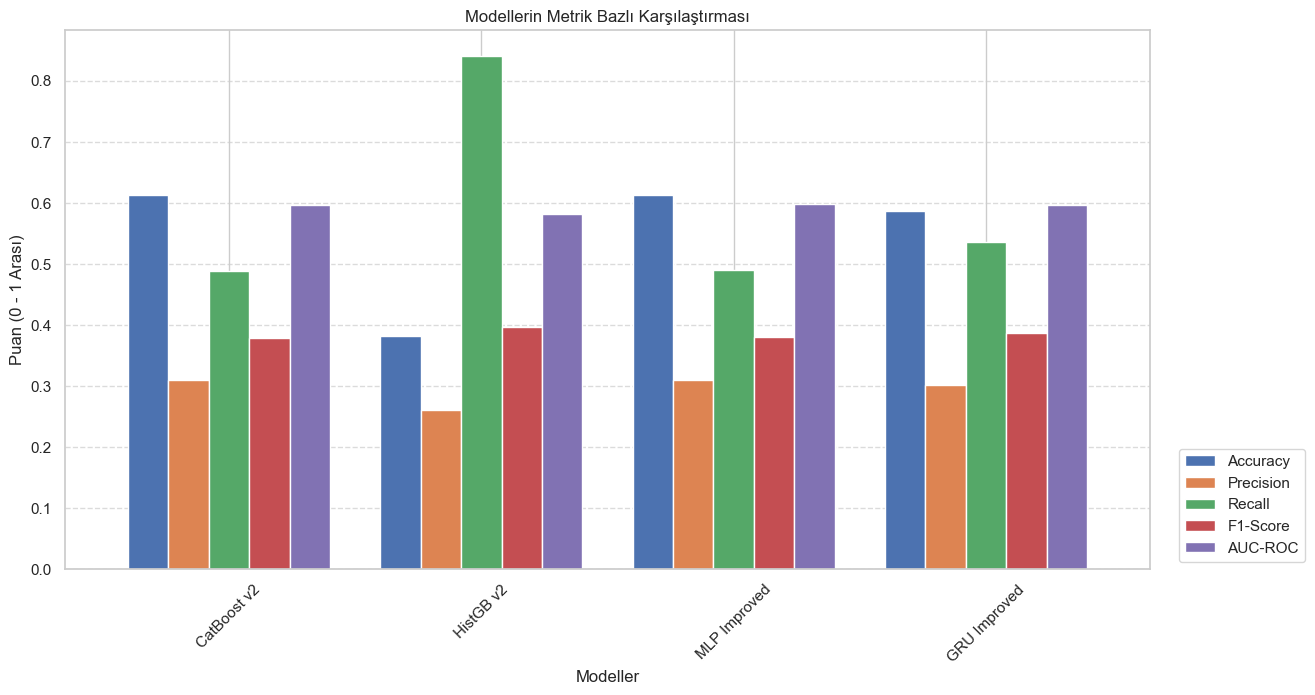

In [42]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Verileri tutmak için bir liste oluşturuyoruz
comparison_list = []

for res in results:
    model_name = res["Model"]
    y_prob = roc_data[model_name] # Olasılık değerleri
    y_pred = (y_prob > 0.5).astype(int) # Eşik değerine göre 0 veya 1 tahmini
    
    # Metrikleri hesapla
    metrics = {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_prob)
    }
    comparison_list.append(metrics)

# Listeyi Pandas DataFrame'e çeviriyoruz
df_comparison = pd.DataFrame(comparison_list).set_index("Model")

# 1. Tabloyu Ekrana Yazdır
print("--- Model Performans Karşılaştırma Tablosu ---")
display(df_comparison.sort_values(by="F1-Score", ascending=False))

# 2. Görselleştirme (Bar Chart)
plt.figure(figsize=(12, 6))
df_comparison.plot(kind='bar', figsize=(14, 7), width=0.8)
plt.title("Modellerin Metrik Bazlı Karşılaştırması")
plt.ylabel("Puan (0 - 1 Arası)")
plt.xlabel("Modeller")
plt.legend(loc='lower right', bbox_to_anchor=(1.15, 0))
plt.grid(axis='y', linestyle='--', alpha=0.7)MLP Improved	
plt.xticks(rotation=45)
plt.show()

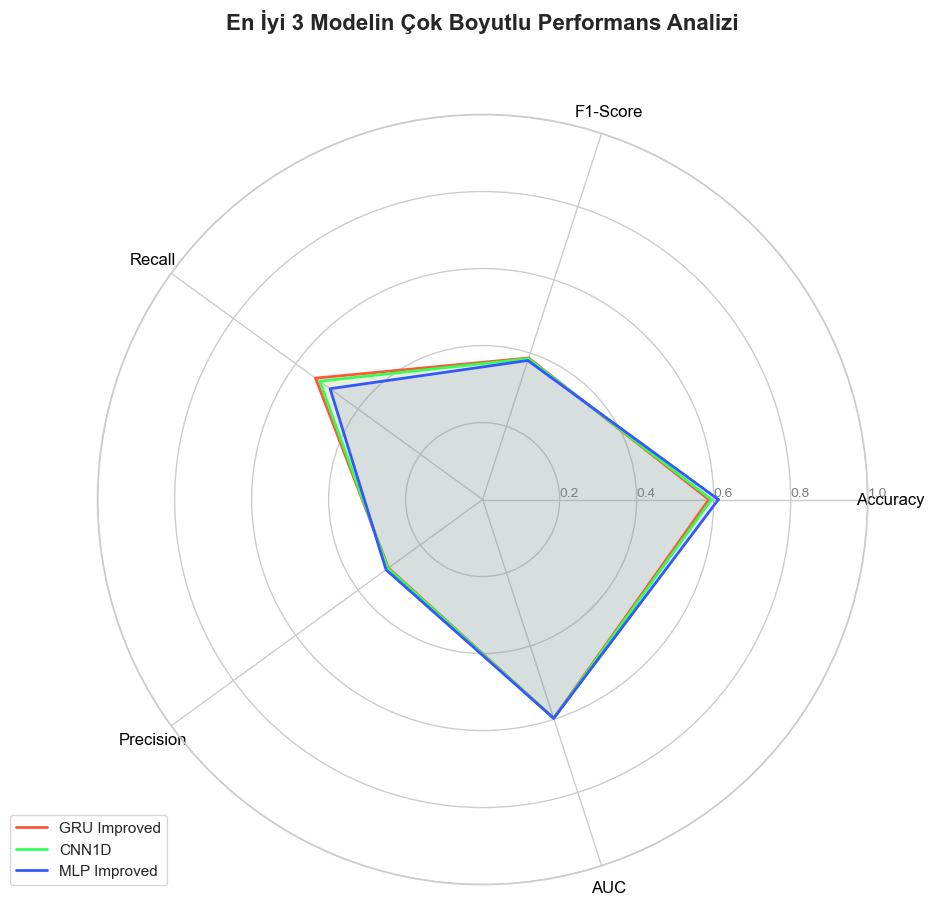

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Grafik stili ayarları
sns.set_style("whitegrid")

# Analiz edilecek en iyi 3 model (Örnek: MLP Improved, ResNet, CNN1D)
# df_8 tablosundan F1 skoruna göre ilk 3'ü alıyoruz
top_models = df_8.head(3)
categories = ['Accuracy', 'F1-Score', 'Recall', 'Precision', 'AUC']
N = len(categories)

# Açıları hesaplama
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1] # Grafiği kapatmak için

plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# Renk paleti
colors = ['#FF5733', '#33FF57', '#3357FF']

for i, (index, row) in enumerate(top_models.iterrows()):
    values = row[categories].tolist()
    values += values[:1] # Grafiği kapatmak için
    
    # Çizim
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=row['Model'], color=colors[i])
    ax.fill(angles, values, color=colors[i], alpha=0.1)

# Eksen ayarları
plt.xticks(angles[:-1], categories, color='black', size=12)
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)
plt.ylim(0, 1)

plt.title("En İyi 3 Modelin Çok Boyutlu Performans Analizi", size=16, weight='bold', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

Modeller test ediliyor...
Başarıyla Yüklendi: MLP Base
Başarıyla Yüklendi: GRU Base
Başarıyla Yüklendi: MLP Advanced
Başarıyla Yüklendi: GRU Advanced
Başarıyla Yüklendi: MLP Improved
Başarıyla Yüklendi: GRU Improved
Başarıyla Yüklendi: CNN1D
Başarıyla Yüklendi: ResNet


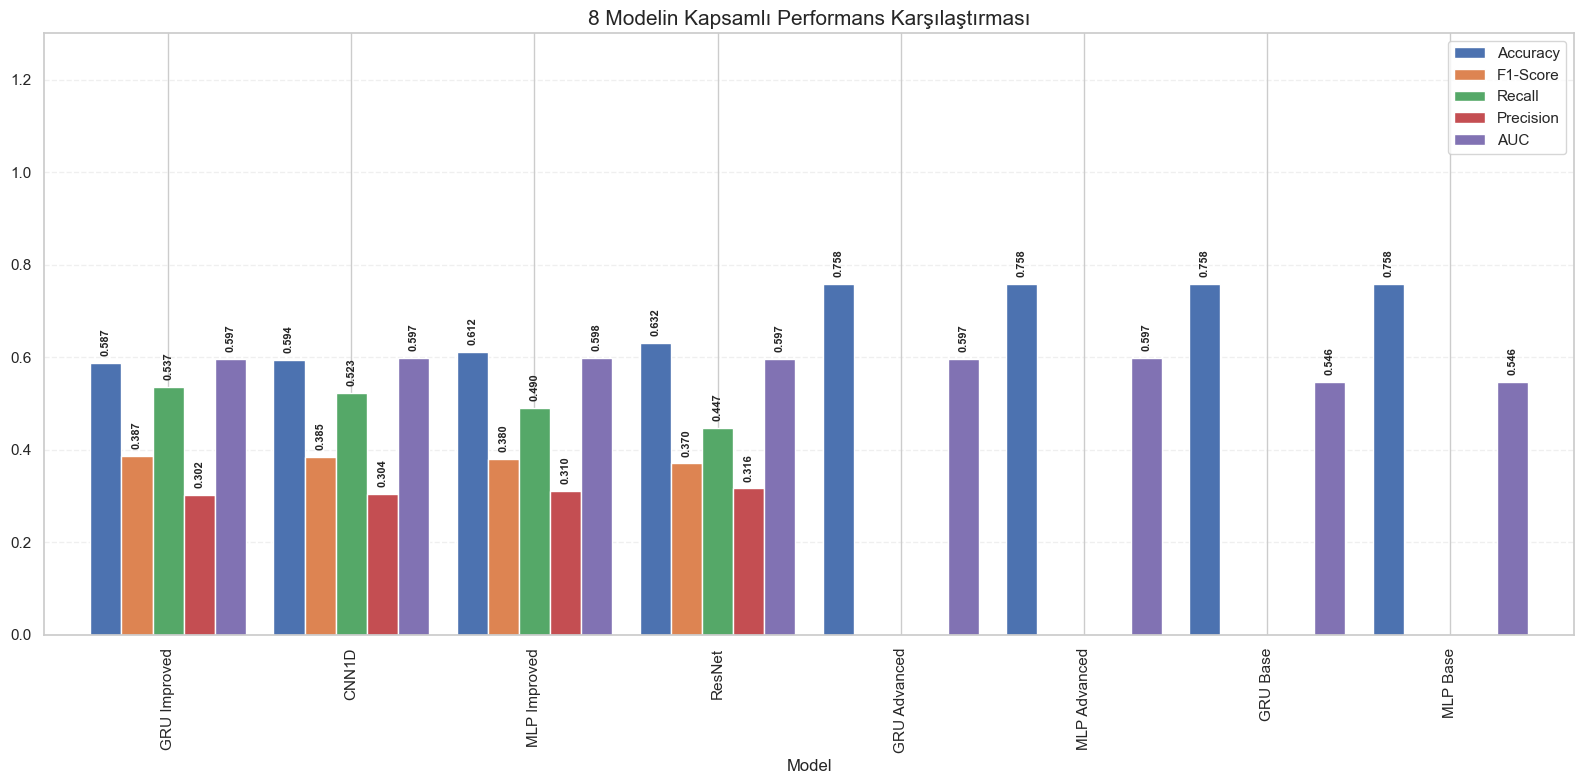


--- DETAYLI PERFORMANS TABLOSU ---


,Model,Accuracy,F1-Score,Recall,Precision,AUC
5,GRU Improved,0.587481,0.386716,0.536552,0.302297,0.597098
6,CNN1D,0.594430,0.384688,0.523017,0.304225,0.597408
4,MLP Improved,0.612239,0.379784,0.489773,0.310136,0.597536
7,ResNet,0.631707,0.370269,0.446675,0.316184,0.596841
3,GRU Advanced,0.757600,0.000000,0.000000,0.000000,0.597046
2,MLP Advanced,0.757600,0.000000,0.000000,0.000000,0.597497
1,GRU Base,0.757600,0.000000,0.000000,0.000000,0.545732
0,MLP Base,0.757600,0.000000,0.000000,0.000000,0.545732


In [84]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- 1. MİMARİLERİN HATASIZ (POINT-FIX) TANIMLANMASI ---

# A. Base ve Advanced Modeller İçin (64-32 yapısı)
class EnesMLP_Standard(nn.Module):
    def __init__(self, input_size):
        super(EnesMLP_Standard, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.network(x)

class EnesGRU_Standard(nn.Module):
    def __init__(self, input_size):
        super(EnesGRU_Standard, self).__init__()
        self.gru = nn.GRU(input_size, 64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, 1)
    def forward(self, x):
        _, h = self.gru(x); return self.fc(h[-1])

# B. Improved Modeller İçin (128-64 yapısı)
class EnesMLP_Improved(nn.Module):
    def __init__(self, input_size):
        super(EnesMLP_Improved, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Linear(64, 1)
        )
    def forward(self, x): return self.network(x)

class EnesGRU_Improved(nn.Module):
    def __init__(self, input_size):
        super(EnesGRU_Improved, self).__init__()
        self.gru = nn.GRU(input_size, 128, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(128, 1)
    def forward(self, x):
        _, h = self.gru(x); return self.fc(h[-1])

# C. CNN1D Mimarisi
class EnesCNN1D(nn.Module):
    def __init__(self, input_size):
        super(EnesCNN1D, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=2), nn.ReLU(), # 6 -> 5
            nn.Conv1d(32, 64, kernel_size=2), nn.ReLU() # 5 -> 4
        )
        self.fc_block = nn.Sequential(
            nn.Linear(256, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        return self.fc_block(x)

# D. ResNet Mimarisi
class ResBlock(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(size, size), nn.BatchNorm1d(size), nn.ReLU(),
            nn.Linear(size, size), nn.BatchNorm1d(size)
        )
        self.relu = nn.ReLU()
    def forward(self, x): return self.relu(x + self.block(x))

class EnesResNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.init_layer = nn.Linear(input_size, 128)
        self.res_blocks = nn.Sequential(ResBlock(128), ResBlock(128))
        self.output_layer = nn.Linear(128, 1)
    def forward(self, x):
        x = x.squeeze(1) if x.dim() == 3 else x
        x = torch.relu(self.init_layer(x))
        x = self.res_blocks(x)
        return self.output_layer(x)

# --- 2. MODELLERİ YÜKLEME VE TEST ---

final_model_files = {
    "MLP Base": "best_mlp_model_base.pth", "GRU Base": "best_gru_model_base.pth",
    "MLP Advanced": "best_mlp_model_adv.pth", "GRU Advanced": "best_gru_model_adv.pth",
    "MLP Improved": "best_mlp_model_improved.pth", "GRU Improved": "best_gru_model_improved.pth",
    "CNN1D": "best_cnn1d_model.pth", "ResNet": "best_resnet_model.pth"
}

results, roc_data = [], {}

print("Modeller test ediliyor...")

for name, path in final_model_files.items():
    if not os.path.exists(path): continue
    input_dim = 4 if "base" in name.lower() else 6
    try:
        # Mimari seçimi
        if "base" in name.lower() or "advanced" in name.lower():
            model = EnesMLP_Standard(input_dim) if "mlp" in name.lower() else EnesGRU_Standard(input_dim)
        elif "improved" in name.lower():
            model = EnesMLP_Improved(input_dim) if "mlp" in name.lower() else EnesGRU_Improved(input_dim)
        elif "cnn" in name.lower(): model = EnesCNN1D(input_dim)
        elif "resnet" in name.lower(): model = EnesResNet(input_dim)

        model.load_state_dict(torch.load(path))
        model.eval()

        with torch.no_grad():
            x_input = X_test_tensor[:, :input_dim]
            # CNN ve GRU için boyut ayarlama (MLP ve ResNet düz alır)
            if "mlp" not in name.lower() and "resnet" not in name.lower(): 
                x_input = x_input.unsqueeze(1)
            
            probs = torch.sigmoid(model(x_input)).numpy().flatten()
            preds = (probs > 0.5).astype(int)

        results.append({
            "Model": name, 
            "Accuracy": accuracy_score(y_test, preds), 
            "F1-Score": f1_score(y_test, preds), 
            "Recall": recall_score(y_test, preds),        # EKLENDİ
            "Precision": precision_score(y_test, preds),  # EKLENDİ
            "AUC": roc_auc_score(y_test, probs)
        })
        roc_data[name] = probs
        print(f"Başarıyla Yüklendi: {name}")
    except Exception as e:
        print(f"Yükleme Hatası ({name}): {e}")

# --- 3. 8 MODELİN TAM PERFORMANS GRAFİĞİ VE TABLOSU ---

if results:
    df_8 = pd.DataFrame(results).sort_values("F1-Score", ascending=False)
    
    # Grafikte gösterilecek metrikleri seçiyoruz (Hepsi eklendi)
    metrics_to_plot = ["Accuracy", "F1-Score", "Recall", "Precision", "AUC"]
    
    ax = df_8.set_index("Model")[metrics_to_plot].plot(kind='bar', figsize=(16, 8), width=0.85)
    
    # Çubukların üzerine değerleri yazma
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height():.3f}', 
                        (p.get_x() + p.get_width()/2., p.get_height()), 
                        ha='center', va='bottom', fontsize=8, fontweight='bold', 
                        xytext=(0, 5), textcoords='offset points', rotation=90)
            
    plt.title("8 Modelin Kapsamlı Performans Karşılaştırması", fontsize=15)
    plt.ylim(0, 1.3) # Değerler üst üste binmesin diye biraz artırdık
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n--- DETAYLI PERFORMANS TABLOSU ---")
    display(df_8)